In [1]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SciPy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow
import statistics as stats
from collections import defaultdict
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model                                                         

In [7]:
(x_train, y_train), (x_test, y_test)=tensorflow.keras.datasets.fashion_mnist.load_data()
#similar to mnist
#(x_train, y_train), (x_test, y_test)=tensorflow.keras.datasets.fashion_mnist.load_data()

In [8]:
x_train = tensorflow.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tensorflow.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tensorflow.expand_dims(x_train, axis=3, name=None)
x_test = tensorflow.expand_dims(x_test, axis=3, name=None)
x_train = tensorflow.repeat(x_train, 3, axis=3)
x_test = tensorflow.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

y_train = tensorflow.one_hot(y_train.astype(np.int32), depth=100)
y_test = tensorflow.one_hot(y_test.astype(np.int32), depth=100)

In [9]:
model_name = vgg16
input_t =(32,32, 3)
model = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune1 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune4 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

In [10]:
# get the layer index
def getLayerIndex(model_i, layer_name):
    for pos, layer_g in enumerate(model_i.layers):
        if layer_g.name == layer_name:
            return pos


In [11]:
# get the convolved layers into an array for looping
convolved_layers = []

for layer in model.layers:

    t = np.array(layer.get_weights()).ndim
    array = np.array(layer.get_weights())
    if (model_name != resnet50) or (model_name != vgg16):
        if (len(array) > 0) and (t > 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))
    if (model_name == resnet50) or (model_name == vgg16):
        if len(array) > 0 and (t != 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))

# get the total number of weights in the array
total_layer_weights = 0
sum_positives = 0
sum_negatives = 0

# create a dictionary with layer index and positive values identified
layer_positives_dict = defaultdict(list)

# create a dictionary for storing the layers and their +ve values probabilities
layer_probs_dict = defaultdict(list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [12]:
# list the convolved layers
for c_layer in range(len(convolved_layers)):
    # create array for array matrices,feature values and convolved values for each layer
    layer_array_matrices = []
    layer_feature_sums = []
    layer_convolved_values_sum = []

    # get the arrays matrices(batches) pixel
    for i in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0])):
        # get the values for each feature
        ######print("channels(image):"+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])))
        for x in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])):
            # return all the values in the convolutional feature
            total_array = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x])
            # return all the negative values in the convolutional feature
            x2 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) < 0
            for c in range(len(x2)):
                ###print("all the trues in depth: " + str(c + 1) + " are for feature: " + str(x + 1))
                sum_negatives += sum(x2[c])
                # print(sum(x2[c]))
            # return all the values
            for y in range(len(total_array)):
                total_layer_weights += len(total_array[y])

            x1 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) > 0
            # get the values for each channel
            for a in range(len(x1)):
                value_pix = sum(x1[a])
                # get the positive values
                sum_positives += value_pix

                ######print(value_pix)
    list_sums = []
    list_sums.append((str(convolved_layers[c_layer]), sum_positives))
    layer_positives_dict.update(list_sums)

    # print the probabilities for each layer
    layer_pos_prob = sum_positives / total_layer_weights

    # create +ves values array
    positives_array = []
    for key, val in layer_positives_dict.items():
        # print(key, "corresponds to:",val," positive values")
        positives_array.append(val)
       
    list_layer_probs = []
    list_layer_probs.append((str(convolved_layers[c_layer]), layer_pos_prob))
    layer_probs_dict.update(list_layer_probs)

In [13]:
median_layer = stats.median(convolved_layers)

# create dictionary for storing selected median layers
second_layer_probs_dict = defaultdict(list)
# store the new list of layers to be matched with the mean probability
second_half_layers = []

# store all probabilities for the selected upper half layers
second_half_probs = []
# loop through the layers and print those layers above the median
for lyr, val in layer_probs_dict.items():
    # print(lyr, "Layer prob:", val)
    if int(lyr) > median_layer:
        # store the probabilities of the upper half selected convolved layers
        #print(lyr, "Layer prob:", val)
        # update the sum of selected layers probabilities
        second_half_probs.append(val)
        second_half_layers.append((lyr, val))
        second_layer_probs_dict.update(second_half_layers)

# get the mean of the layers
selected_layers_mean = stats.mean(second_half_probs)
final_selected_layers = []
# now get the final layers list whose value exceed the mean
for s_lyr, v in second_layer_probs_dict.items():
    # get the probabilities that are lower than the mean probability
    if v < selected_layers_mean:
        # store the probabilities of the upper half selected convolved layers
        final_selected_layers.append(s_lyr)

In [14]:

# for positive cosines similarities
pcs_h_layers =[1,12,15,16]
pcs_l_layers =[4,5,7,9] #lower cosine
for sb_layer in model.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model, sb_layer.name)
    #for b in final_selected_layers:
    for b in pcs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for negative cosine similarities
# for model 2
# for positive cosines similarities
ncs_h_layers =[1,12,13,15,16]
ncs_l_layers =[4,5,7,8]
for sbs_layer in model2.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model2, sbs_layer.name)
    #for b in final_selected_layers:
    for b in ncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for positive negative cosine similarities
# for model 3
pncs_h_layers =[1,4,5,12,13] #high cosine,,
pncs_l_layers =[7,9,15,16] #lower cosine
for sbs_layer in model3.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model3, sbs_layer.name)
    #for b in final_selected_layers:
    for b in pncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)


#finetune by removeing the last layer
for lst_layer in model_tune1.layers[:-2]:
    lst_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 2nd last layer
for scnd_st_layer in model_tune2.layers[:-3]:
    scnd_st_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 3rd last layer
for thrd_layer in model_tune3.layers[:-4]:
    thrd_layer.trainable = False
    

    
####end of the last layer
#for feature extraction
for ftr_layer in model_tune4.layers:
    ftr_layer.trainable = False

# try the transfer learning model
to_res = (224, 224)


block1_conv1 True
block4_conv2 True
block5_conv1 True
block5_conv2 True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True
block5_pool True


In [15]:

t_model = Sequential()
t_model.add(model)
t_model.add(Flatten())
t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(64, activation='relu'))
t_model.add(layers.Dropout(0.5))
t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model2 = Sequential()
t_model2.add(model2)
t_model2.add(Flatten())
t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(64, activation='relu'))
t_model2.add(layers.Dropout(0.5))
t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model3 = Sequential()
t_model3.add(model3)
t_model3.add(Flatten())
t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(64, activation='relu'))
t_model3.add(layers.Dropout(0.5))
t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model4 = Sequential()
t_model4.add(model_tune1)
t_model4.add(Flatten())
t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(64, activation='relu'))
t_model4.add(layers.Dropout(0.5))
t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(100, activation='softmax'))

#for model 2
t_model5 = Sequential()
t_model5.add(model_tune2)
t_model5.add(Flatten())
t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(64, activation='relu'))
t_model5.add(layers.Dropout(0.5))
t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(100, activation='softmax'))

#for model 2
t_model6 = Sequential()
t_model6.add(model_tune3)
t_model6.add(Flatten())
t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(64, activation='relu'))
t_model6.add(layers.Dropout(0.5))
t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(100, activation='softmax'))


#for model 2
t_model7 = Sequential()
t_model7.add(model_tune3)
t_model7.add(Flatten())
t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(64, activation='relu'))
t_model7.add(layers.Dropout(0.5))
t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(100, activation='softmax'))

In [16]:
#positive cosine similarity
t_model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history = t_model.fit(x_train, y_train, batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 36s 36ms/step - loss: 4.1171 - accuracy: 0.1525 - val_loss: 2.5003 - val_accuracy: 0.7704
Epoch 2/20
907/907 [==============================] - 32s 35ms/step - loss: 2.6946 - accuracy: 0.6295 - val_loss: 2.1068 - val_accuracy: 0.8089
Epoch 3/20
907/907 [==============================] - 32s 35ms/step - loss: 2.3482 - accuracy: 0.7338 - val_loss: 1.8836 - val_accuracy: 0.8285
Epoch 4/20
907/907 [==============================] - 32s 35ms/step - loss: 2.1405 - accuracy: 0.7799 - val_loss: 1.7160 - val_accuracy: 0.8418
Epoch 5/20
907/907 [==============================] - 32s 35ms/step - loss: 1.9798 - accuracy: 0.8110 - val_loss: 1.5839 - val_accuracy: 0.8494
Epoch 6/20
907/907 [==============================] - 32s 35ms/step - loss: 1.8597 - accuracy: 0.8253 - val_loss: 1.5078 - val_accuracy: 0.8579
Epoch 7/20
907/907 [==============================] - 32s 35ms/step - loss: 1.7458 - accuracy: 0.8378 - val_loss: 1.3598 - val_accuracy:

In [17]:
#negative cosine similarity look
#for model2
t_model2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history2 = t_model2.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 33s 35ms/step - loss: 4.0178 - accuracy: 0.1788 - val_loss: 2.4985 - val_accuracy: 0.7679
Epoch 2/20
907/907 [==============================] - 32s 35ms/step - loss: 2.6359 - accuracy: 0.6290 - val_loss: 2.0810 - val_accuracy: 0.8104
Epoch 3/20
907/907 [==============================] - 32s 35ms/step - loss: 2.3172 - accuracy: 0.7250 - val_loss: 1.8881 - val_accuracy: 0.8333
Epoch 4/20
907/907 [==============================] - 32s 35ms/step - loss: 2.1247 - accuracy: 0.7746 - val_loss: 1.7298 - val_accuracy: 0.8444
Epoch 5/20
907/907 [==============================] - 32s 35ms/step - loss: 1.9780 - accuracy: 0.8019 - val_loss: 1.6159 - val_accuracy: 0.8545 1.9782 - accuracy
Epoch 6/20
907/907 [==============================] - 32s 35ms/step - loss: 1.8606 - accuracy: 0.8202 - val_loss: 1.5141 - val_accuracy: 0.8579
Epoch 7/20
907/907 [==============================] - 32s 35ms/step - loss: 1.7584 - accuracy: 0.8336 - val_loss: 1.40

In [18]:
#for model3
t_model3.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history3 = t_model3.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 33s 36ms/step - loss: 4.0498 - accuracy: 0.1626 - val_loss: 2.6453 - val_accuracy: 0.7378
Epoch 2/20
907/907 [==============================] - 32s 35ms/step - loss: 2.8208 - accuracy: 0.5835 - val_loss: 2.2533 - val_accuracy: 0.7968
Epoch 3/20
907/907 [==============================] - 32s 35ms/step - loss: 2.4725 - accuracy: 0.7005 - val_loss: 2.0175 - val_accuracy: 0.8243
Epoch 4/20
907/907 [==============================] - 32s 35ms/step - loss: 2.2750 - accuracy: 0.7544 - val_loss: 1.8881 - val_accuracy: 0.8395
Epoch 5/20
907/907 [==============================] - 32s 35ms/step - loss: 2.1238 - accuracy: 0.7851 - val_loss: 1.7355 - val_accuracy: 0.8496
Epoch 6/20
907/907 [==============================] - 32s 35ms/step - loss: 1.9781 - accuracy: 0.8110 - val_loss: 1.6156 - val_accuracy: 0.8588
Epoch 7/20
907/907 [==============================] - 32s 35ms/step - loss: 1.8725 - accuracy: 0.8259 - val_loss: 1.5006 - val_accuracy:

In [19]:
#for model3
t_model4.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history4= t_model4.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)



Epoch 1/20
907/907 [==============================] - 14s 14ms/step - loss: 4.4276 - accuracy: 0.0692 - val_loss: 3.2165 - val_accuracy: 0.5464
Epoch 2/20
907/907 [==============================] - 13s 14ms/step - loss: 3.3618 - accuracy: 0.3462 - val_loss: 2.7861 - val_accuracy: 0.6621
Epoch 3/20
907/907 [==============================] - 13s 14ms/step - loss: 2.9980 - accuracy: 0.4811 - val_loss: 2.5326 - val_accuracy: 0.7071
Epoch 4/20
907/907 [==============================] - 13s 14ms/step - loss: 2.7608 - accuracy: 0.5636 - val_loss: 2.3303 - val_accuracy: 0.7370
Epoch 5/20
907/907 [==============================] - 13s 14ms/step - loss: 2.5828 - accuracy: 0.6169 - val_loss: 2.1718 - val_accuracy: 0.7557
Epoch 6/20
907/907 [==============================] - 13s 14ms/step - loss: 2.4407 - accuracy: 0.6509 - val_loss: 2.0356 - val_accuracy: 0.7677
Epoch 7/20
907/907 [==============================] - 13s 14ms/step - loss: 2.3097 - accuracy: 0.6807 - val_loss: 1.9163 - val_accuracy:

In [20]:
#for model3
t_model5.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history5 = t_model5.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 16s 17ms/step - loss: 4.1165 - accuracy: 0.1434 - val_loss: 2.8787 - val_accuracy: 0.6259
Epoch 2/20
907/907 [==============================] - 15s 17ms/step - loss: 3.0589 - accuracy: 0.4636 - val_loss: 2.4813 - val_accuracy: 0.7105
Epoch 3/20
907/907 [==============================] - 15s 17ms/step - loss: 2.6972 - accuracy: 0.5854 - val_loss: 2.2414 - val_accuracy: 0.7438
Epoch 4/20
907/907 [==============================] - 15s 17ms/step - loss: 2.4855 - accuracy: 0.6469 - val_loss: 2.0705 - val_accuracy: 0.7642
Epoch 5/20
907/907 [==============================] - 15s 17ms/step - loss: 2.3102 - accuracy: 0.6898 - val_loss: 1.9276 - val_accuracy: 0.7779
Epoch 6/20
907/907 [==============================] - 15s 17ms/step - loss: 2.1845 - accuracy: 0.7168 - val_loss: 1.8085 - val_accuracy: 0.7880
Epoch 7/20
907/907 [==============================] - 15s 17ms/step - loss: 2.0793 - accuracy: 0.7348 - val_loss: 1.7027 - val_accuracy:

In [21]:
#for model3
t_model6.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history6 = t_model6.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 19s 20ms/step - loss: 4.0692 - accuracy: 0.1522 - val_loss: 2.7377 - val_accuracy: 0.6653
Epoch 2/20
907/907 [==============================] - 18s 19ms/step - loss: 2.9412 - accuracy: 0.4998 - val_loss: 2.3726 - val_accuracy: 0.7558
Epoch 3/20
907/907 [==============================] - 18s 19ms/step - loss: 2.5999 - accuracy: 0.6216 - val_loss: 2.1496 - val_accuracy: 0.7882
Epoch 4/20
907/907 [==============================] - 18s 19ms/step - loss: 2.3807 - accuracy: 0.6881 - val_loss: 1.9790 - val_accuracy: 0.8023
Epoch 5/20
907/907 [==============================] - 18s 19ms/step - loss: 2.2366 - accuracy: 0.7215 - val_loss: 1.8434 - val_accuracy: 0.8135
Epoch 6/20
907/907 [==============================] - 18s 19ms/step - loss: 2.1016 - accuracy: 0.7513 - val_loss: 1.7240 - val_accuracy: 0.8200
Epoch 7/20
907/907 [==============================] - 18s 19ms/step - loss: 1.9987 - accuracy: 0.7667 - val_loss: 1.6234 - val_accuracy:

In [22]:
#for model3
t_model7.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(lr=1e-5,momentum=0.9),metrics=['accuracy'])
history7 = t_model7.fit(x_train, y_train,  batch_size=64, shuffle=True,validation_data=(x_test, y_test), epochs=20, verbose=1)


Epoch 1/20
907/907 [==============================] - 19s 20ms/step - loss: 3.8776 - accuracy: 0.1985 - val_loss: 2.6456 - val_accuracy: 0.7724
Epoch 2/20
907/907 [==============================] - 18s 19ms/step - loss: 2.8092 - accuracy: 0.5842 - val_loss: 2.2472 - val_accuracy: 0.8048
Epoch 3/20
907/907 [==============================] - 18s 19ms/step - loss: 2.4888 - accuracy: 0.6857 - val_loss: 2.0237 - val_accuracy: 0.8210
Epoch 4/20
907/907 [==============================] - 18s 19ms/step - loss: 2.2722 - accuracy: 0.7383 - val_loss: 1.8693 - val_accuracy: 0.8295
Epoch 5/20
907/907 [==============================] - 18s 19ms/step - loss: 2.1245 - accuracy: 0.7635 - val_loss: 1.7296 - val_accuracy: 0.8334
Epoch 6/20
907/907 [==============================] - 18s 19ms/step - loss: 2.0048 - accuracy: 0.7846 - val_loss: 1.6261 - val_accuracy: 0.8439
Epoch 7/20
907/907 [==============================] - 18s 19ms/step - loss: 1.8936 - accuracy: 0.7981 - val_loss: 1.5431 - val_accuracy:

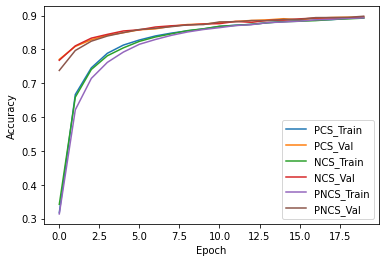

In [25]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history2.history['val_accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='lower right')
#plt.legend(['high_cos_train', 'high_cos_val','low_cos_train','low_cos_val'], loc="center right", bbox_to_anchor=(1.6, 0.5))
#fig1.savefig('3plots_fashion_mnist_vgg16.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

In [ ]:
fig2 = plt.figure()
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_accuracy'])
#plt.plot(history6.history['val_loss'])
plt.plot(history7.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc='lower right')
#plt.legend(['high_cos_train', 'high_cos_val','low_cos_train','low_cos_val'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('mul_fashion_mnist_vgg16.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()